<a href="https://colab.research.google.com/github/joshmurr/machine-learnings/blob/master/pix2pix/pix2pix2webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training Your Own GAN: Start to Finish**
## Josh Murr
---
# __Intro__

In this notebook you'll be taken through the process of training a GAN from start to finish.

The model we will be using is based on [Pix2Pix](https://arxiv.org/pdf/1611.07004.pdf) which is a __conditional GAN__ or __cGAN__. This basically means the input to the data is _conditioned_ with additional information meaning _'it is possible to direct the data generation process.'_ (For more information [see here](https://arxiv.org/pdf/1411.1784.pdf)). In the case of _Pix2Pix_ the training process involves giving the discriminator a _target image_ (the desired outcome) and the generator an _input image_ which is an obfuscated version of the target image. Thus we hope that the generator learns to convert the obfuscated image into the target image (hence image-to-image translation).

You will build a dataset by splitting a YouTube video of your choice into 1000 images, training a small model on this dataset, viewing the results and finally converting and downloading the model to be used interactively on [this online platform](https://learning-to-learn-to-see.netlify.app/) (more information on this at the end of the notebook).

This work was inspired by the work [Learning to See](http://www.memo.tv/works/learning-to-see/) by [Memo Akten](http://www.memo.tv/).



## __Instructions__

The code has been written for you, but to make the model your own you will need edit some details. There are comments throughout the code which will instruct what to edit. Colab Notebooks use Python as a programming language. Comments in Python are any lines which start with a '__#__' and there will often be extra information in the comments. If you are asked to change the value of a variable, you change whatever comes _after_ the equals sign. If I asked you to change the value of `myVariable` (below) you would change 10 to something else:

```python
# This is a comment.
myVariable = 10
def myFunction():
  pass
```

(Sorry if that is basic and boring, but it's worth getting some common language if you are not a programmer!)

Each block of code (or __cell__) is a small chunk which needs to be __run__ (or *evaluated* if you're being picky). To run a cell you can either press the the circular play button which appears on the top left of the cell, or you can press __Shift+Enter__ which will run the cell and move you on to the next. Some cells will give you some output text which appears below the cell, others wont; some will take a moment to complete, others will be quick. If you accidentally run a cell it's normally not a problem, the only one which takes a while to finish is the cell which actually trains the model. Everything else you should be able to re-run if you want to change anything.

# __Step 1__

Click on __Runtime__ in the menu at the top of the page, select __Change Runtime Type__ and select __GPU__ from the dropdown menu and press __OK__. This will give us a GPU which will make the training process much quicker!

# __Step 2__

Now you just need to move down through the cells running each cell in sequence. There will be another heading and some instructions if you need to change anything.

In [21]:
# This just installs some extra programs that we need
!pip install --upgrade --quiet youtube_dl tensorflowjs

In [22]:
# Install some Python packages...
import numpy as np
import tensorflow as tf
from tensorflow import keras
import sys
import os
import time
import cv2

from matplotlib import pyplot as plt
from IPython import display

import math
import random

In [23]:
# This will link you Google Drive to this Colab session so that we can save
# files there. Run the cell and then you will be given a link to click on in the
# output. It's just Google Drive asking for permission, and then it will give
# you a long code which you paste back in a box in the cell output, then press
# enter.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
# Make some directories...
for directoryName in ['/content/dataset', 
                      '/content/dataset/train', 
                      '/content/dataset/test', 
                      '/content/drive/MyDrive/DI_Workshop_Ouput',
                      '/content/drive/MyDrive/DI_Workshop_Ouput/images',
                      '/content/drive/MyDrive/DI_Workshop_Ouput/model'
                      ]:
  try:
    os.mkdir(directoryName)
  except:
    pass

In [26]:
# Some helper functions we will use to make the dataset

from __future__ import unicode_literals
import youtube_dl


class MyLogger(object):
    def debug(self, msg):
        pass

    def warning(self, msg):
        pass

    def error(self, msg):
        print(msg)


def my_hook(d):
    if d['status'] == 'finished':
        print('Done downloading.')

def download_youtube_video(_url):
  ydl_opts = {
      'format': '(mp4)[height>=256][height<=400]',
      'outtmpl': '%(id)s.%(ext)s',
      'logger': MyLogger(),
      'progress_hooks': [my_hook],
  }
  try:
    with youtube_dl.YoutubeDL(ydl_opts) as ydl:
        result = ydl.extract_info(_url, download=True)
  except:
    print("ERROR downloading video :(")

  if 'entries' in result:
    video = result['entries'][0]
  else:
    video = result

  return video

def analyse_video(_videoPath):
  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameCount = 0
  darkFrames = []
  validFrames = []

  while success:
    grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    average = grey.mean(axis=0).mean(axis=0)

    if average < 2:
      darkFrames.append(frameCount)
    else:
      validFrames.append(frameCount)
    
    success, frame = vidcap.read()
    frameCount += 1
  
  print(f'Found {len(darkFrames)} dark frames.')
  return validFrames, darkFrames

def extract_frames(_videoPath, _outputPath):
  SIZE = 256
  MAX = 1000
  count = 0
  id = 0
  validFrames, darkFrames = analyse_video(_videoPath)
  doubles = []
  frames = []

  if MAX > len(validFrames):
    numDoubles = MAX - len(validFrames)
    doubles = np.random.choice(validFrames, size=numDoubles, replace=False)
    frames = validFrames
  else:
    frames = np.random.choice(validFrames, size=MAX, replace=False)

  vidcap = cv2.VideoCapture(_videoPath)
  success, frame = vidcap.read()

  frameHeight = frame.shape[0]
  frameWidth = frame.shape[1]

  scaleFactor = SIZE / frameHeight
  newWidth = int(frameWidth * scaleFactor)
  padding = int((newWidth - SIZE) / 2)

  while success:
    if count in frames:
      frame = cv2.resize(frame, (newWidth, SIZE), interpolation=cv2.INTER_AREA)
      crops = []

      if count in doubles:
        crops = [frame[0:SIZE, 0:SIZE],
                frame[0:SIZE, padding*2:SIZE+padding*2]]
      else:
        crops = [frame[0:SIZE, padding:SIZE+padding]]

      for crop in crops:
        try:
          cv2.imwrite(os.path.join(_outputPath, f'{id:04}.jpg'), crop)
          id += 1
        except:
          print("Error saving frame.")
          pass
    
    count += 1
    success, frame = vidcap.read()

  print(f"Saved {id} images from video '{videoInfo['title']}'")

  return id

# __Step 3__

Find a video on YouTube which is about 4-10 minutes long. The video can be anything but ideally it will be generally consistent throughout. So timelapse video are perfect, [like this video of clouds forming](https://www.youtube.com/watch?v=NJfI_GaEyJw), or [this video of life underwater](https://www.youtube.com/watch?v=J2BKd5e15Jc) has nice consistent colours and forms. However it is entirely up to you, maybe it would be interesting to get a random video of Lady Gaga dresses.. who knows!

Paste the YouTube video URL in the cell below, __replacing the url that is between the single quotes__.

If the URL is long like this:

```
https://www.youtube.com/watch?v=NJfI_GaEyJw&ab_channel=wizard327
                                           ^
                       We don't need the stuff after this & symbol.
```

just trim the end off after (and including) the '__&__' symbol.

In [27]:
# Replace the URL between the single quotes.
# Running this cell will download the video from YouTube using YouTubeDL.

url = 'https://www.youtube.com/watch?v=J2BKd5e15Jc' # Coral Reef
videoInfo = download_youtube_video(url)
videoFile = "{0}.{1}".format(videoInfo['webpage_url'].split('=')[-1], videoInfo['ext'])

Done downloading.


# __Step 3a (Optional)__

If your video has an intro and an outro we can trim that off! Change the `startTime` and `endTime` values below. The values need to be in seconds, so if the good bit of the video start at 38 seconds then enter `38` for `startTime`. If the end credits start at 9:14, then an easy way to find the seconds is `(9*60)+14`.

__If you don't need to trim the video down then just don't run the cell below.__

In [28]:
# Optional trimming of the video to remove intro / end credits.
# Skip this if your video does not need trimming.

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

def trim_video(_video, _start, _end):
  trimmedVideo = f"trimmed.{videoInfo['ext']}"
  ffmpeg_extract_subclip(videoFile, _start, _end, targetname=trimmedVideo)
  return trimmedVideo


startTime = 38
endTime = (9*60)+14
videoFile = trim_video(videoFile, startTime, endTime)


[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i J2BKd5e15Jc.mp4 -ss 38.00 -t 516.00 -vcodec copy -acodec copy trimmed.mp4
... command successful.


# __Continue from here...__

In [29]:
# Extract 1000 frames from the video downloaded
NUM_IMAGES = extract_frames(f"/content/{videoFile}", '/content/dataset/train')

Found 31 dark frames.
Saved 1000 images from video 'Exploring the Coral Reef: Learn about Oceans for Kids - FreeSchool'


In [30]:
# Move 20 frames into a seperate folder for testing at the end.
# This isn't crucial for this model, but it's always good to test your model
# on some data it has not seen during training.
for i in range(0, NUM_IMAGES, 50):
  os.rename(f'/content/dataset/train/{i:04}.jpg', f'/content/dataset/test/{i:04}.jpg')

In [31]:
# A bunch of helper functions which will be used in training
def load(image_file):    
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  input_image = tf.image.rgb_to_grayscale(image)

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(image, tf.float32)

  return input_image, real_image

def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image

def random_crop(input_image, real_image):
  offset_h = math.floor(random.random()*(input_image.shape[0] - IMG_HEIGHT))
  offset_w = math.floor(random.random()*(input_image.shape[1] - IMG_WIDTH))
      
  input_image = tf.image.crop_to_bounding_box(input_image, offset_h, offset_w, IMG_HEIGHT, IMG_WIDTH)
  real_image = tf.image.crop_to_bounding_box(real_image, offset_h, offset_w, IMG_HEIGHT, IMG_WIDTH)

  return input_image, real_image

def greyscale(input_image):
  input_image = tf.image.rgb_to_grayscale(input_image)
  return input_image

def downscale_upscale(input_image):
  w = tf.shape(input_image)[1]
  h = tf.shape(input_image)[0]
  # Downscale
  input_image = tf.image.resize(input_image, [h//24, w//24], method=tf.image.ResizeMethod.AREA)
  # Upscale
  input_image = tf.image.resize(input_image, [h, w], method=tf.image.ResizeMethod.BICUBIC)
  return input_image

def random_brightness(input_image):
  input_image = tf.image.random_brightness(input_image, 0.2)
  return input_image

def random_contrast(input_image):
  input_image = tf.image.random_contrast(input_image, 0.85, 1.15)
  return input_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

def load_image_train(image_file, do_normalize=True):
  """
  Loads image from dataset and applies pre-processing manipulations
  and resizes and normalizes
  """
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image = downscale_upscale(input_image)
  input_image = random_brightness(input_image)
  input_image = random_contrast(input_image)
  if do_normalize:
      input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file, do_normalize=True):
  """
  Loads image from dataset and resizes and normalizes
  """
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                  IMG_HEIGHT, IMG_WIDTH)
  input_image = downscale_upscale(input_image)
  input_image = random_brightness(input_image)
  input_image = random_contrast(input_image)
  if do_normalize:
      input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image


def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0][:, :, 0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

def save_images(model, dataset, r, dir, prefix):
  j = 0
  for inp, tar in dataset.take(r):
    prediction = model(inp, training=True)
    fig = plt.figure(figsize=(15,15))

    display_list = [inp[0][:, :, 0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    fig.savefig('{}/{}{}.png'.format(dir, prefix, j))
    plt.show()
    j += 1

In [42]:
# Define some variables
BUFFER_SIZE = 1000
BATCH_SIZE = 4
IMG_WIDTH = 256
IMG_HEIGHT = 256
LAMBDA = 100
OUTPUT_CHANNELS = 3
EPOCHS = 1

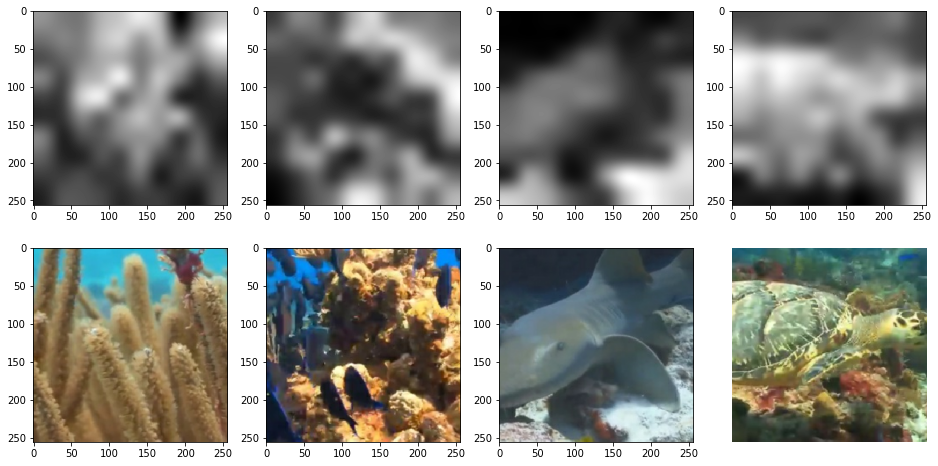

In [36]:
# Test the training and pre-processing pipeline.
# You should see 4 blurry images in the top row which are the 'input' images,
# and four images beneath which are the 'target' images.
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i in range(4):
    inp, re = load_image_train(f'/content/dataset/train/{(i+1) * 78:04}.jpg', do_normalize=False)
    axes[0][i].imshow(inp[:,:,0]/255.0, cmap='gray')
    axes[1][i].imshow(re/255.0)
    plt.axis('off')
plt.show()

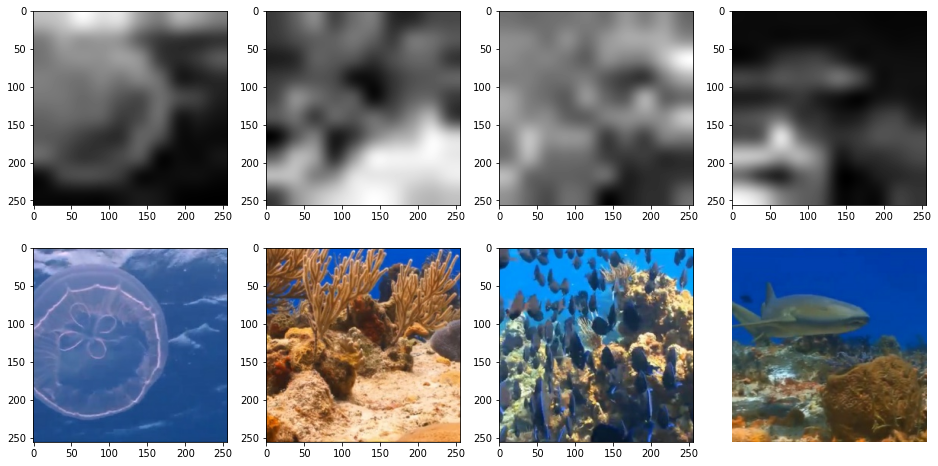

In [37]:
# Test the testing pipeline. Pretty much the same as above but with images from
# the smaller testing dataset.
fig, axes = plt.subplots(2, 4, figsize=(16,8))
for i in range(4):
    inp, re = load_image_test(f'/content/dataset/test/{(i+1) * 50:04}.jpg', do_normalize=False)
    axes[0][i].imshow(inp[:,:,0]/255., cmap='gray')
    axes[1][i].imshow(re/255.0)
    plt.axis('off')
    
plt.show()

In [38]:
# Prepare the dataset for Tensorflow
train_dataset = tf.data.Dataset.list_files('/content/dataset/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files('/content/dataset/test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [39]:
# Helper functions to create the Generator and Discriminator
# This is the model itself, if you're interested in seeing what a model looks
# like in code then this is it! Although it's not the simplest model...

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                            kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator(size='medium'):
  assert size == 'medium' or size == 'large'
  inputs = tf.keras.layers.Input(shape=[256,256,1])

  layer_opts = {
      'medium' : {
          'down_sequence': [8, 16, 32, 64, 128, 256, 512, 512],
          'up_sequence':[ 512, 256, 128, 64, 32, 16, 8]
      },
      'large' : {
          'down_sequence': [64, 128, 256, 512, 512, 512, 512, 512],
          'up_sequence':[ 512, 512, 512, 512, 256, 128, 64]
      },
  }

  down_stack = [downsample(k, 4, apply_batchnorm=(i != 0)) for i, k in enumerate(layer_opts[size]['down_sequence'])]
  up_stack = [upsample(k, 4, apply_dropout=(i < 3)) for i, k in enumerate(layer_opts[size]['up_sequence'])]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

# __Model Size__

You have the option here of a __medium__ sized model or a __large__ one. The size refers to the number of convolution kernels used inside the generator. The __medium__ model will train a lot faster and also run faster once trained, whereas the larger model will learn more variation and detail and so will produce better quality images once trained but will take longer to train and run slower.

Uncomment the line below to choose the size you would like...

In [40]:
# Create the Generator, Discriminator, optimizers and an object to handle
# the loss.

model_size = 'medium'
# model_size = 'large'

generator = Generator(size=model_size)
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

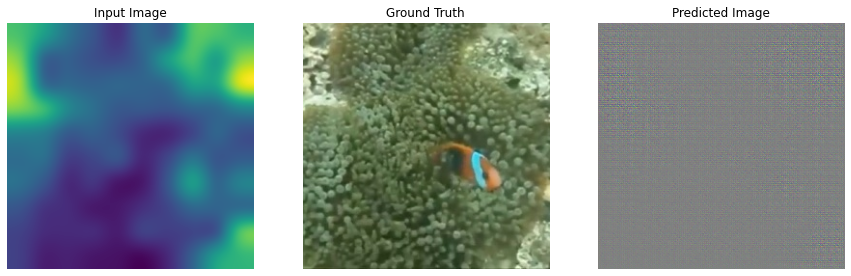

In [41]:
# Run the Generator once to make sure it's working. With a brand new generator
# you should see a grey-ish square as the output under 'Predicted Image'.
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

In [43]:
# The core training routine
@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [44]:
# The outer training routine
import datetime

def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

# __Step 4__
## __Train the model!__

Running the cell below will begin the training process. It will train for 100 epochs, and each epoch will take approximately 30 seconds on the GPU. You should see an example output at the start of each epoch giving you a sense of how the model is training.

Once it is finished you will find a folder in your Google Drive called `DI_Workshop_Output` which will contain some images automatically saved. Scroll down to the bottom for the final instructions!

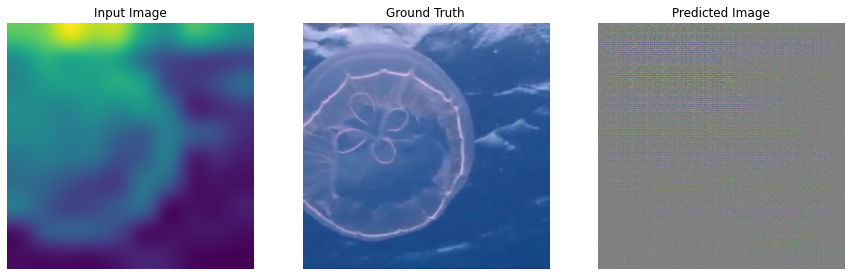

Epoch:  0
....................................................................................................
....................................................................................................
.............................................
Time taken for epoch 1 is 59.31471014022827 sec

2021-11-05 12:23:14.344375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:23:14.369109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:23:14.369757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-05 12:23:14.370796: I ten

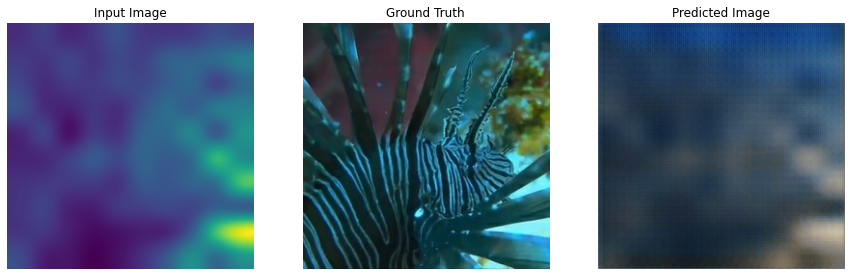

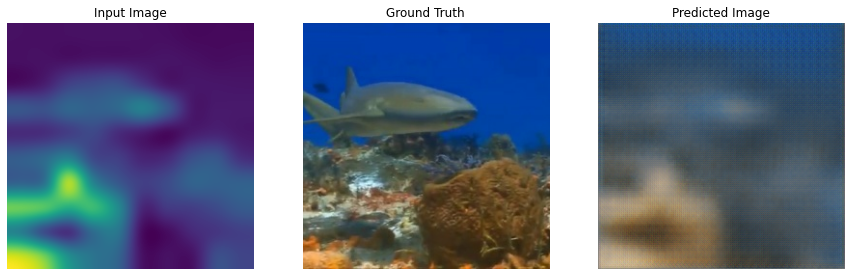

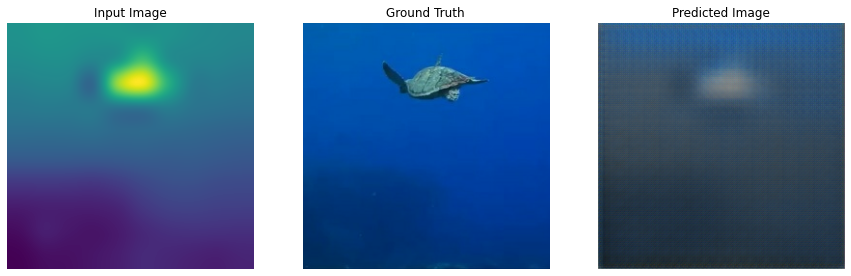

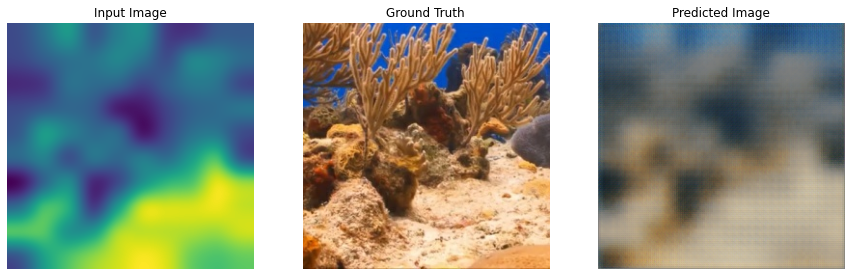

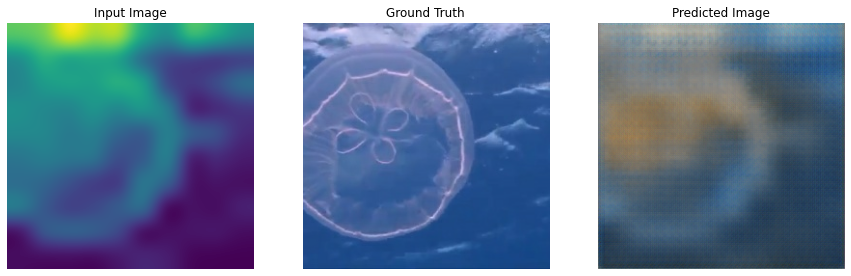

In [45]:
# Running this cell will train the model!

fit(train_dataset, EPOCHS, test_dataset)

generator.save('/content/drive/MyDrive/DI_Workshop_Ouput/model/generator.h5')

!tensorflowjs_converter \
    --input_format=keras \
    --output_format=tfjs_graph_model \
    --quantize_uint8=* \
    --weight_shard_size_bytes=4194304 \
    '/content/drive/MyDrive/DI_Workshop_Ouput/model/generator.h5' \
    '/content/drive/MyDrive/DI_Workshop_Ouput/model/converted' \

save_images(generator, test_dataset, 5, '/content/drive/MyDrive/DI_Workshop_Ouput/images', 'a')

# __Step 5__

The model is automatically converted into something we can use online and is saved into `DI_Workshop_Output/model/converted` on your Google Drive. Right click on the folder called `converted`, click __Download__ and it will download the folder as a `.zip` file.

Once downloaded extract the contents of the `.zip` file and head over to [learning-to-learn-to-see.netlify.app](https://learning-to-learn-to-see.netlify.app/). You should be able to upload the `model.json` file and the the rest of the `.bin` files and play with your model using your webcam!

The speed that the model will run will depends on the computer you have. If you did not specifically buy a computer/laptop with a special graphics card the model will likely run fairly slow, but well enough that you get a sense of how the model behaves to your input. If you have a gaming computer or something similar with a decent GPU in it it should run pretty quickly! This model has been reduced in size to make the training and inference quicker (inference is running the model once it has been trained). The caveat of a smaller model is that it will not hold as much information and thus the quality and variation in the output is reduced.

# __Final Words__

I hope it's been useful to you to see how a GAN is trained from start to finish and I hope you ended up with something that you can interact with. I have always felt seeing the whole process is much more informative and rewarding than just using a tool which would be a small part of the overall pipeline.

If you want to do this again (and I encourage you to!) then just rename the folder `DI_Workshop_Output` in your Google Drive to something else and it wont overwrite the model you have. Bare in mind though GANs are memory hungry models and you could quickly fill up your Drive memory allowance if you do this often.